In [1]:
import torch
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

from src.data_pp import fetch_data, preprocess_data, create_dataloaders, create_datasets
from src.network import build_model, train_model, make_predictions, visualize_predictions

In [2]:
if torch.cuda.is_available():
    print(f"CUDA is available! Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Running on CPU.")

start_date = "2024-01-01"
end_date = (datetime.now() - timedelta(days=1)).strftime("%Y-%m-%d")

print(f"Fetching exchange rate data from {start_date} to {end_date}...")
df = fetch_data(start_date, end_date)

print(f"Data shape: {df.shape}")
print("Sample data:")
print(df.head())

target_currency = "USD"
print(f"Preprocessing data for {target_currency}...")
processed_df = preprocess_data(df, target_currency=target_currency)

# Create datasets
max_prediction_length = 30  # Forecast horizon (30 days)
max_encoder_length = 90  # Look-back window (90 days)

print("Creating time series datasets...")
training, validation = create_datasets(
    processed_df,
    max_prediction_length=max_prediction_length,
    max_encoder_length=max_encoder_length
)

print("Creating dataloaders...")
train_dataloader, val_dataloader = create_dataloaders(training, validation)

print("Dataloaders created.")

CUDA is available! Using GPU: NVIDIA GeForce RTX 2070 SUPER
Fetching exchange rate data from 2024-01-01 to 2025-04-14...
Data shape: (9900, 3)
Sample data:
        date currency    rate
0 2023-12-29      AUD  1.6263
1 2023-12-29      BGN  1.9558
2 2023-12-29      BRL  5.3618
3 2023-12-29      CAD  1.4642
4 2023-12-29      CHF  0.9260
Preprocessing data for USD...
Creating time series datasets...
Creating dataloaders...
Dataloaders created.


In [3]:
print("Building Temporal Fusion Transformer model...")
model = build_model(training)

print("Training model...")
trainer = train_model(model, train_dataloader, val_dataloader)

c:\KODA\TimeSeriesForecastingDemo\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
c:\KODA\TimeSeriesForecastingDemo\.venv\Lib\site-packages\lightning\pytorch\utilities\parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Building Temporal Fusion Transformer model...
Training model...



   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 92     | train
3  | prescalers                         | ModuleDict                      | 416    | train
4  | static_variable_selection          | VariableSelectionNetwork        | 5.7 K  | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 21.4 K | train
6  | decoder_variable_selection         | VariableSelectionNetwork        | 4.2 K  | train
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K  | train
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K  

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\KODA\TimeSeriesForecastingDemo\.venv\Lib\site-packages\lightning\pytorch\loops\fit_loop.py:310: The number of training batches (40) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Making predictions...
Transposed predictions to correct dimensions
Visualizing predictions...
Raw predictions shape: torch.Size([72, 7, 30])
Sample prediction values (first 3 days):
Quantile 0: [1.0741777 1.0755109 1.0757443]
Quantile 1: [1.0774521 1.0788476 1.0795069]
Quantile 2: [1.0806231 1.0817568 1.0826082]
Quantile 3: [1.0850407 1.0856298 1.0867243]
Quantile 4: [1.0878806 1.0890425 1.0904255]
Quantile 5: [1.0906496 1.091854  1.0931969]
Quantile 6: [1.0957708 1.0958745 1.096621 ]
Error in visualization: too many indices for tensor of dimension 3


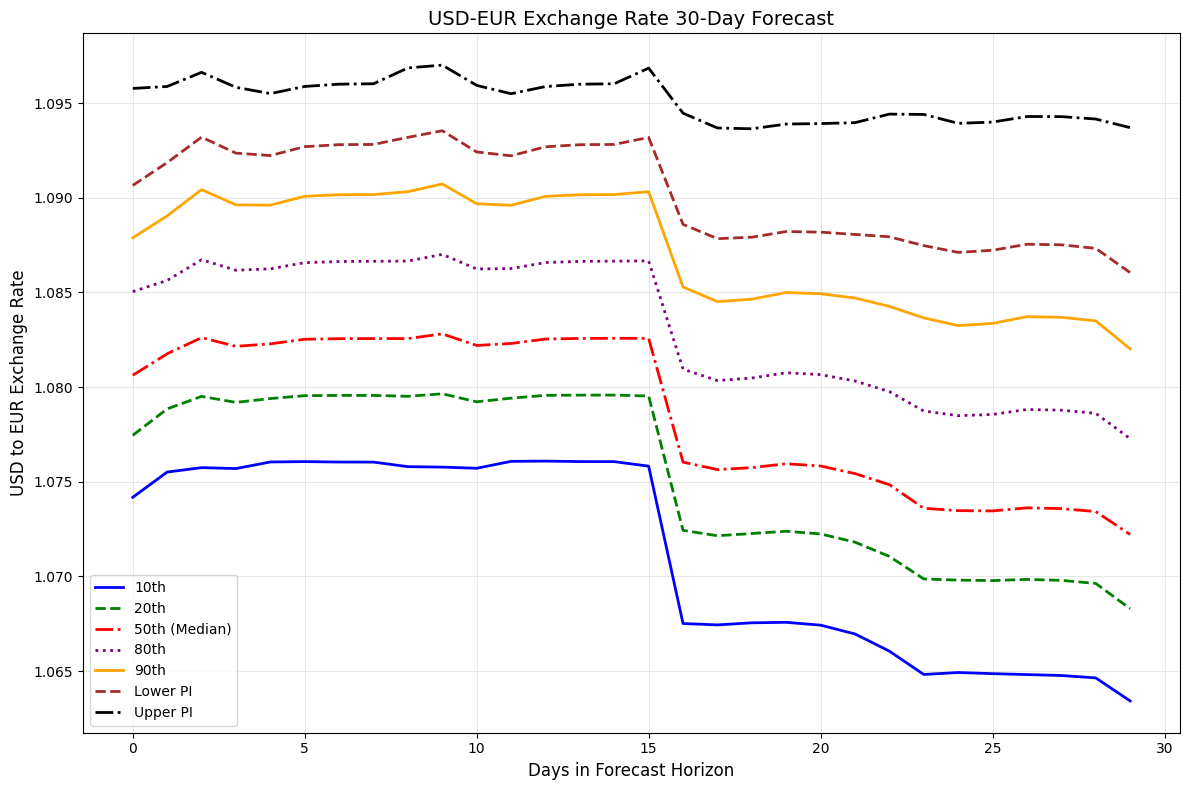

In [4]:

print("Making predictions...")
raw_predictions, x, y, _, _ = make_predictions(model, val_dataloader)

print("Visualizing predictions...")
visualize_predictions(model, raw_predictions, x)
